### **1) Problem formulation**


**Problem:** The problem here is to classify the gender of the participitant based on the audio input. 
We will be using Supervised Machine Learning Models by using features from the librosa python package to retrive information. 

Note: All the participants are labelled manually as female or male since the demographic data is not given

**2) What's Intresting about it**

This project helps to classify the gender based on this we can intrepet many others charecterstics based on the gender for further analysis.This project gives an insight to work with different audio features to classify its environment.

Additionally this project gives an inference of machine learning model that best suits this application. Furthermore, We will explore different methods to choose best hyperparameteters and compare the effectiveness of supervised models for this application.

This project can be used for age based classification by changing some of the features.



## **3.Machine Learning pipeline**

The below describes the Machine Learning Pipeline

**Input**
The csv file consists of name of the audio files along with the Area Spot, environment, Participant Number recorded in different filiming locations of London and 2498 audios in mp3 format which have been imported from the google drive

**Data Preprocessing**
There are totally 176 participants, 6 areas and 36 spots in our data. Since the demographic data is not provided I manually identifying the gender of 176 participants in a separate csv file and merged this into audio dataset for further processing.

**Feature Extraction**

In this stage we are loading a collection of audio files along with the dataframe where name of the audio file is given as index.  Here we are extracting spectral features using librosa library using different functions. It returns and array*(X)* of these features and a binary boolean label *(y)* which is *True* for *Male* and *False* for *female*. 

**Feature Analysis**

In this stage data having high skewness is transformed into low skewness using logorithmic, square, cube root math functions. We are reducing the skewness so that the data has smoothned curve.If the skewness of the data lies between -1 to 1 it is normally distributed. Data is inconsistent so the data is standardised by using sklearn library where the transformed data has mean as zero and varience as 1.

**Training and Tuning the model**

The processed data is given as input to the models after spliting into 70% Training and 30% Testing data. Followed by the Supervised Machine Learning Models to predict labels as female and male participitants. Each model is accesed for evaluation using accuracy metric, precision, recall, f1-score. Using RandomizedSearchCV best hyperparameters are selected that best suits the model. 

**Model Evaluation**

In this stage we will further select the best model using accuracy obtained for each model on the validation dataset(30%). The final model is selected based on accuracy, confusion matrix, classification report so that the suitable model is not biased towards any predictors.

**Output** Output of each model will be the predictions based on gender of each model

### **4 Transformation stage**

**Input**

Transformation Stage is the major part in this project. raw.wav data and the dataframe were given. Initially files name were fetched and there respective gender were identified.

**Transformation**

We are decomposing the audio files into timeseries with a sampling rate of 22050. Now we further need to reduce the dimensions by extracting below mentioned spectral features.

*Note:If we are using raw audio signals as input we need to deal with thousands of dimensionals. This results into Curse of Dimensioanlity problem.* 

In this approach we are dealing with the extracted various features from these audio clips. Any audio file consists of various spectral features extracting these feature can be useful for data learning.

**Spectral Bandwidth(spec_bw)**  It is calculated by evaluating the difference between upper and lower frequencies in a continuous band of frequencies.


***Zero crossings rate :***It is the measure of number of times the amplitude of the audio signals passes through zero in the given time interval. This feature is extensively used in music genre identification, speech recognition and environment sound recognition. It is the best way to distinguish voiced and unvoiced sounds. A higher Zero crossings indicates that there is a high frequency noisy signals.

***Tempo :*** Tempo is defined as the speed of a music beat.
(https://musicinformationretrieval.com/tempo_estimation.html

***Mel Frequency Cepstral Coefficients feature(MFCC)*** 
Mel Frequency Cepstral Coefficients feature defines characteristics that describe the overall form of a curve of the amplitude spectrum and simulates the specification of human voice. This feature is widely used in modern apps performing the detection of voice activity (VAD). https://www.youtube.com/watch?v=WJI-17MNpdE

***Output***

An array of all the extracted features and their associated predictor labels were returned



In [ ]:
#Importing all the neccesary libraries
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

from sklearn.metrics import accuracy_score,matthews_corrcoef,classification_report,ConfusionMatrixDisplay,confusion_matrix
from sklearn import metrics

from scipy.stats import skew
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import IPython.display as ipd
from tqdm import tqdm
import librosa

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,# sr -sampling range
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [ ]:
def getXy(files,labels_file, scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  #fetching the file name and extracting features through signal processing from librosa library
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    file_name = file.split('/')[-1]
    yi = labels_file.loc[fileID]['Gender']=='Male'
    
    fs = None # if None, fs would be 22050
    #Reading the audio file where x is the wave format and sr is the sampling rate
    x, fs = librosa.load(file,sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,fs,winLen=0.02)
    #Extracting various spectral and audio features   
    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)
    mfcc = librosa.feature.mfcc(x,n_mfcc=40, sr=fs)
    zero_crossings = librosa.zero_crossings(x, pad=False)
    onset_env = librosa.onset.onset_strength(x, sr=fs)
    spec_bw = librosa.feature.spectral_bandwidth(x, sr=fs)
    tempo = librosa.beat.tempo(x, sr=fs)
    xi = [power,pitch_mean,pitch_std,voiced_fr,np.mean(mfcc),np.mean(zero_crossings),np.mean(onset_env),np.mean(spec_bw),tempo[0]]
    X.append(xi)
    y.append(yi)

  return np.array(X),np.array(y)

### **5 Modelling**

Supervised Models were implemented in this notebook which is widely used for classification and regression tasks.

1.  **SVM**-I choosed this method since it uses an ***N***-dimensional hyperplane that separates ***N***-distinct features into two different classes. This method is extremely useful for higher dimensions.  
2.   **Random Forest**-It builds decision trees on a collection of samples and predicts by considering the majority vote for classfication.I choosed this method as it avoids overfitting as this model collects samples randomly and considers majority ranking for classification or average for regression.
1.  **Xgboost**-https://www.analyticsvidhya.com/blog/2018/09/an-end-to-end-guide-to-understand-the-math-behind-xgboost/


### **6 Methodology**

***Data Exploration and analysis***

To begin with all the extracted features were placed in a Dataframe. Data having highskewness is transformed and standardised using standard scaler from sklearn library.The standardised data is analysed using pearson correlation coefficient. A heatmap is placed in this notebook which shows the relationship between all the attributes.

***Spliting and Training the model***

Data is divided into 70% training data and 30% test data here randomness while spliting the data is controlled by a random number generator and stratify parameter splits the data in equal proportions based on the proportion of gender from the dataset.

***Model performance*** 

Initially training data is fit to each model and their accuracy is calculated based their performance their associated hyperparamters are optimized.
Performance of the features for each model is plotted in this notebook.

**Model evaluation**

Evalution of the model is accesed through 5 evaluation metrics accuracy, Precision, recall,fscore and confusion matrix.

**OUTPUT**

The output of the pipeline will be a predicted labels as Female or Male.

### **7 Dataset**
In this notebook we are building a machine learning pipeline using a csv file and 7-seconds audio audio clips( .wav files) recorded in different filiming locations of London.


In the below glob function from python retrives the files paths that has "wav" path in it.

In [ ]:
# Accessing all the audio files from the google drive using glob
sample_path = '/content/drive/MyDrive/Data/MLEndLS_1/sample_1/*.wav'
files = glob.glob(sample_path)
len(files)

2498

In [ ]:
#Loading Mlend csv file 
MLENDLS_df_advance = pd.read_csv('/content/MLEndLS _advance.csv')

There are totally 176 participants in our data. Since the demographic data is not provided I manually identifying the gender of 176 participants in a separate csv file and merging this into audio dataset for further processing.

In [ ]:
#Loading a csv file of 176 participants along with the observed gender 
student_gender=pd.read_csv('/content/students_id_with_gender.csv')

In [ ]:
#Merging the csv file and the participitant gender file to build a single frame work
data=pd.merge(MLENDLS_df_advance, student_gender, on ='Participant').set_index('file_id')
data.drop(data[['Unnamed: 2']],axis=1,inplace=True)

In [ ]:
display(data['Gender'].shape)
display(data.isna().any())

(2498,)

area           False
spot           False
in_out         False
Participant    False
Gender         False
dtype: bool

It can be observed that all the participants are assigned with an observed gender.

In [ ]:
print("The total number of participants are {} respectively".format(len(data['Participant'].unique())))
unique, counts = np.unique(data['Gender'], return_counts=True)
print("The total number of female and male participants are",dict(zip(unique, counts)))

The total number of participants are 176 respectively
The total number of female and male participants are {'Female': 985, 'Male': 1513}


**Data  Exploration**

The graph below shows the spectogram of different sample of Female and male participants.

It is clear that the amplitude of Female and Male differ over the 7-seconds time span so this can be considered as a feature.

1501.wav


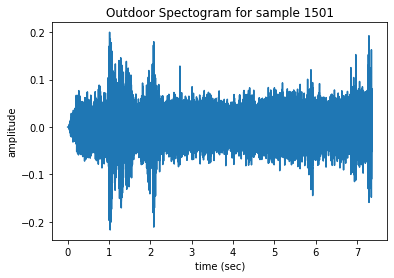

area           southbank
spot                book
in_out           outdoor
Participant         S102
Gender              Male
Name: 1501.wav, dtype: object

In [ ]:
#Visualizing the male audio signal in the wave format
n=1 #0-998
fs = None # Sampling frequency
x, fs = librosa.load(files[n],sr=fs)
fileID = files[n].split('/')[-1]
print(fileID)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.title("Male Spectogram for sample 1501")
plt.show()
display(ipd.Audio(files[n]))
#Information about 'n' audio signal
data.loc[files[n].split('/')[-1]]

1505.wav


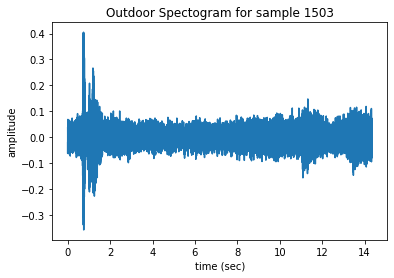

area           westend
spot           charing
in_out          indoor
Participant        S13
Gender          Female
Name: 1505.wav, dtype: object

In [ ]:
#Visualizing the female audio signal in the wave format
n=5
fs = None # Sampling frequency
x, fs = librosa.load(files[n],sr=fs)
fileID = files[n].split('/')[-1]
print(fileID)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.title("Female Spectogram for sample 1503")
plt.show()
display(ipd.Audio(files[n]))
#Information about 'n' audio signal
data.loc[files[n].split('/')[-1]]

In [ ]:
#Placing all the extracted independent variables into X and dependent variable into y using getXy function 
X,y = getXy(files, labels_file=data, scale_audio=True, onlySingleDigit=True)

100%|██████████| 2498/2498 [1:37:16<00:00,  2.34s/it]


In [ ]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
print('The labels vector is', y)

The shape of X is (2498, 9)
The shape of y is (2498,)
The labels vector is [False  True False ... False  True  True]


In [ ]:
#Converting all the features into a dataframe
df = pd.DataFrame({'power': list(X[:,0]), 'pitch_mean': list(X[:, 1]), 'pitch_std':list(X[:, 2]),'voiced_fr':list(X[:, 3]), 'mfcc':list(X[:, 4]),
              'zero_crossings':list(X[:, 5]),'onset_env':X[:,6],'spec_bw':X[:,7],'tempo':list(X[:, 8]),'Gender':list(y)})

In [ ]:
from sklearn.preprocessing import StandardScaler
std=StandardScaler()

In [ ]:
df.isna().any()
#Converting labels into numerical features for data processing
df['Gender']=df['Gender'].astype('int')

**7.2 Cleaning, Tranforming and Data Analysis**


Raw data extracted from the features has high skweness. For effective functioning of our dataset we need to reduce the skewness. Here high positive skewed values are converted using log/cbrt where as negatively skewed values are converted using square math functions. we are transforming the data as to make the data more efficient with less skeweness

**Plotting a graph representing the histogram and skewness of each attribute of data before tranformation and after tranformation**

power - 1.9321216399232035


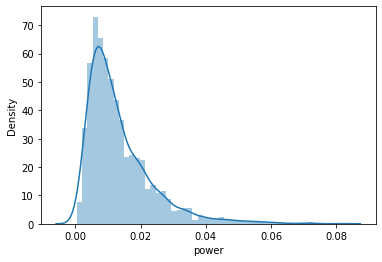

pitch_mean - 0.20709820713529473


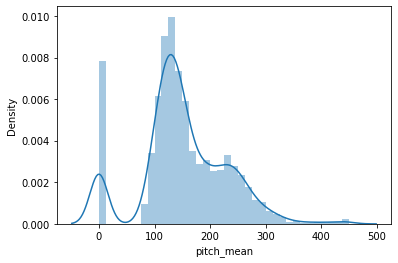

pitch_std - 2.0214120495176635


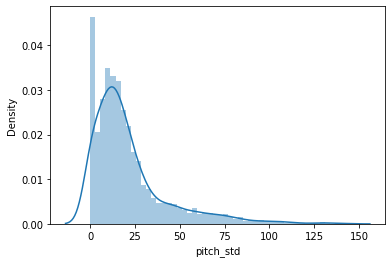

voiced_fr - 3.7427294967107256


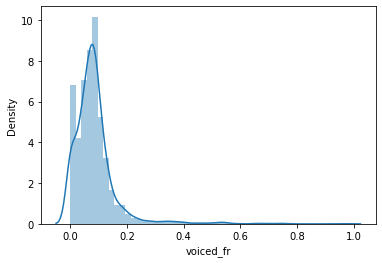

mfcc - -0.8002400572420175


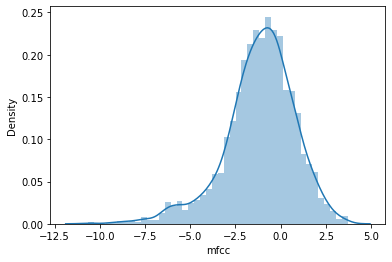

zero_crossings - 3.509379288117832


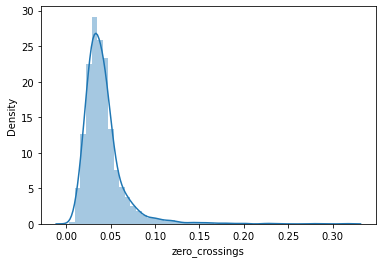

onset_env - 1.169834992363067


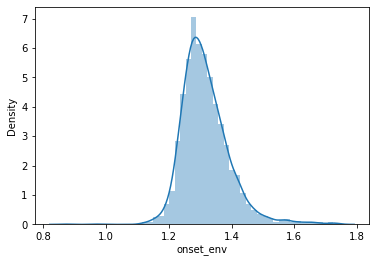

spec_bw - 0.9287146944886631


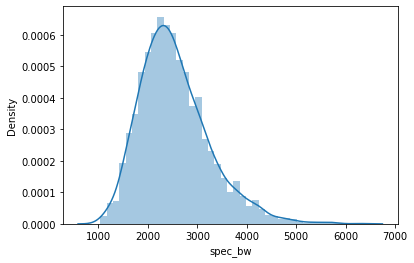

tempo - 0.10183838232917544


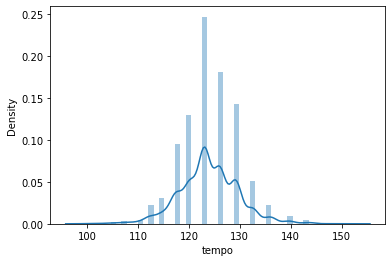

In [ ]:
for col in df:
  if(col!='Gender'):
    print(col,"-",skew(df[col]))
    sns.distplot(df[col]);
  plt.show()

**Data Transformation** In this stage we are transforming the data based on their distribution.  

*   We can observe that pitch_mean of the data at 0 differs from its own distribution so data having pitch_mean zero must be an outlier.
*  Pitch std attribute has zero values in it as we cannot cuberoot or square root zero values we are replacing zero with 0.01.

*  Pitch_std, power,voiced_fr,zero_crossing has positively skewed distribution so we are reducing the skewness by using logorithmic, square root, cube root math functions. 
* *why data should be Transformed*: As the normal distribution has skewness ranging between -1 to 1 we are trying to convert the data into normally distributed through normal or guassian distribution we can derive the nature of the data.

In [ ]:
data=df[df['pitch_mean']!=0.0]
#Replacing zero values with 0.01
data[data['pitch_std']==0]=0.01
#Tranforming data having high skewness
data['pitch_std']=np.cbrt(data['pitch_std'])
#performing log transformation on power as it is heavily skewed
data['power']=np.log(data['power'])
data['onset_env']=np.square(data['onset_env'])
data['voiced_fr']=np.log(data['voiced_fr'])
data['zero_crossings']=np.log(data['zero_crossings'])
data['tempo']=np.square(data['tempo'])
display(data.describe())

power   pitch_mean    pitch_std    voiced_fr         mfcc  \
count  2254.000000  2254.000000  2254.000000  2254.000000  2254.000000   
mean     -4.617663   168.795150     2.657970    -2.584719    -1.310440   
std       0.685103    62.428941     0.772648     0.673044     1.942611   
min      -7.744397     0.010000     0.000024    -5.464891   -10.662400   
25%      -5.069093   122.671825     2.158017    -2.907528    -2.277735   
50%      -4.610763   148.448701     2.563016    -2.519998    -1.111890   
75%      -4.158038   209.480859     3.045974    -2.239913    -0.058759   
max      -2.512774   449.941853     5.220849    -0.026668     3.718372   

       zero_crossings    onset_env      spec_bw         tempo       Gender  
count     2254.000000  2254.000000  2254.000000   2254.000000  2254.000000  
mean        -3.286934     1.738761  2545.904347  15385.031104     0.631331  
std          0.454144     0.217502   719.990766   1516.620598     0.482542  
min         -5.668542     0.000100     0.010000      0.000100     0.000000  
25%         -3.558540     1.607029  2047.919240  14444.511088     0.000000  
50%         -3.291592     1.702861  2443.377299  15140.533447     1.000000  
75%         -3.044700     1.834110  2936.932748  15888.102916     1.000000  
max         -1.149993     3.035331  6298.948947  23103.720589     1.000000

power - -0.10035267646991722


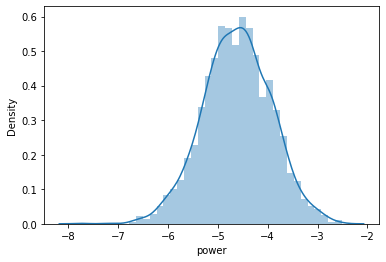

pitch_mean - 1.1628797865129124


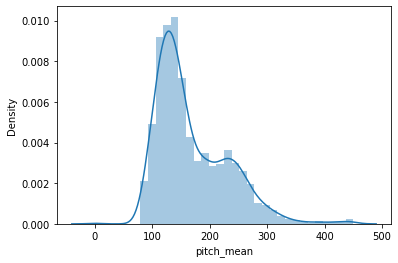

pitch_std - 0.48848823461390767


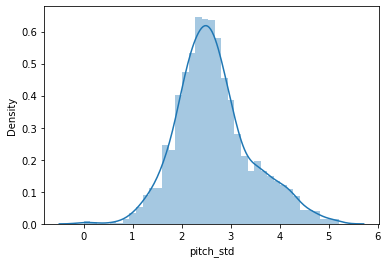

voiced_fr - -0.38585703799090487


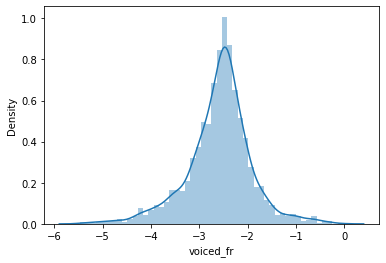

mfcc - -0.8449518749328119


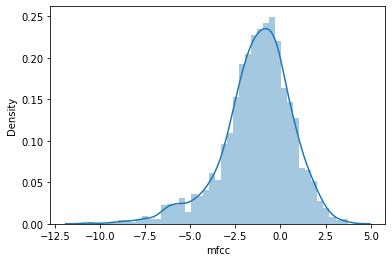

zero_crossings - 0.26817928541139197


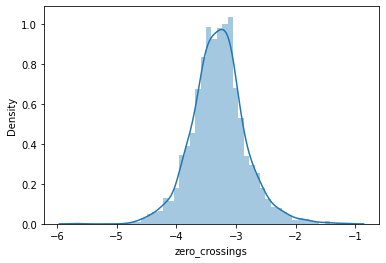

onset_env - 1.0544290126390206


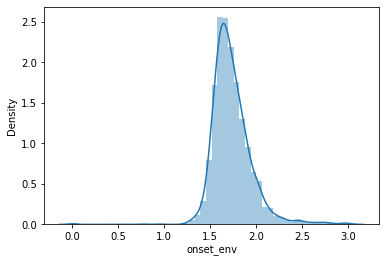

spec_bw - 0.8997284914023577


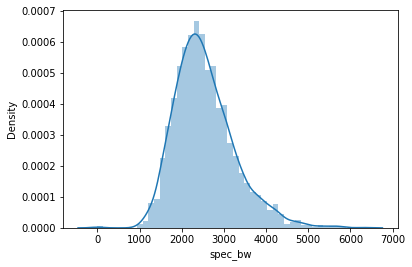

tempo - -0.6062600145139722


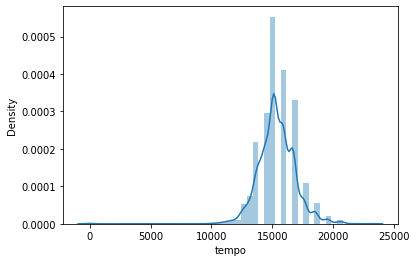

In [ ]:
for col in data:
  if(col!='Gender'):
    print(col,"-",skew(data[col]))
    sns.distplot(data[col]);  
  plt.show()    

**7.2.1 Standardizing the data**

Standardising the tranformed data using standard scaler function sklearn library. All the independent variables are drawn into x and the dependent varible Gender are drawn into labels

In [ ]:
#Converting boolean data type to integer datatype
data['Gender']=data['Gender'].astype(int)
data_1=data.copy()
labels=data['Gender']
data.drop(data[['Gender']],axis=1,inplace=True)
#Standardizing the tranformed data
x = pd.DataFrame(std.fit_transform(data), columns=data.columns, index=data.index)

**7.2.2 Data Analysis**

**Coorelation between features of transformed data**




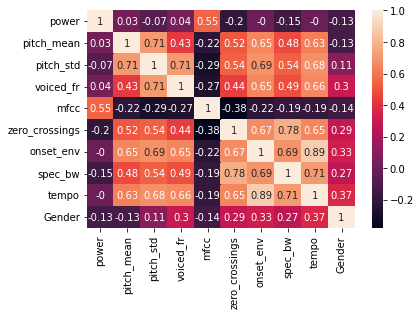

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
cor_matrix=data_1.corr().round(2)
sns.heatmap(cor_matrix, annot=True)
plt.show()

**correlation between features of Male participitants**

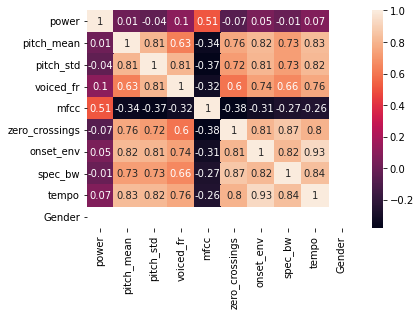

In [ ]:
cor_matrix=data_1[data_1['Gender']==0].corr().round(2)
sns.heatmap(cor_matrix, annot=True)
plt.show()

**correlation between features of Female participitants**

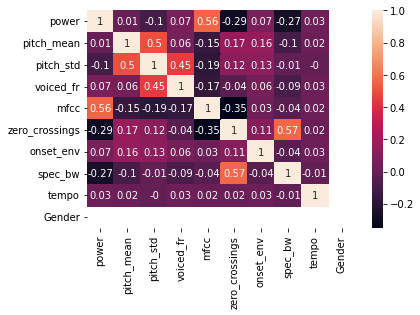

In [ ]:
cor_matrix=data_1[data_1['Gender']==1].corr().round(2)
sns.heatmap(cor_matrix, annot=True)
plt.show()

**Inference**:Correlation is the value lying between -1 and +1. It shows the relationship between the direction and strength of the features.

The closer the value is to 1 (or -1), the stronger the relationship. The closer a number is to 0, the weaker the relationship.

We can observe that features do not have much correlation between the dependent variable and independent variables for female participants.

For the male participants, there is a huge relation between onset_env and tempo. We cannot remove tempo from the dataset since the female participants do not have any relationship between on_set and tempo.

Although there are high correlation values between features for male participants we cannot replace any features since in this notebook evaluating the gender based on features. If we wanna study analysis based on only Male participants we can do replace features.

In [ ]:
#Splitiing the dataframe into training and testing 
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(x,labels,test_size=0.3,random_state=24,stratify=labels)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1577, 9), (677, 9), (1577,), (677,))

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 581, 1: 996}

In [ ]:
unique, counts = np.unique(y_val, return_counts=True)
dict(zip(unique, counts))

{0: 250, 1: 427}

Note: '0' represents Male Participitants and '1' represents female participitants.

### **8 Results**

**8.1 Model Traning and Evaluation using Svm Model**

Training Accuracy 0.8883956880152187
Validation  Accuracy 0.843426883308715
The support vectors are (699, 9)




              precision    recall  f1-score   support

           0       0.73      0.82      0.78       222
           1       0.91      0.85      0.88       455

    accuracy                           0.84       677
   macro avg       0.82      0.84      0.83       677
weighted avg       0.85      0.84      0.85       677



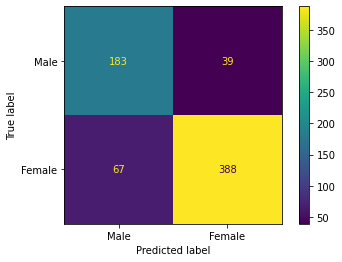

In [ ]:
model  = svm.SVC()
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)
print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))
print('The support vectors are', model.support_vectors_.shape)
svm_train_accuracy=accuracy_score(y_val, yv_p)
print("\n")
#Confusion Matrix
cm = metrics.confusion_matrix(yv_p, (y_val))
cmd_obj=ConfusionMatrixDisplay(cm,display_labels=['Male','Female'])
cmd_obj.plot();
print("\n")
#Classification Report
print(classification_report(yv_p,y_val)) 

**Inference**: SVM is not an optimistic model for this problem.From the Confusion matrix we can infer that this model is incorrectly identifying the Male Participitants and being more favourable female participitants which leads to underfitting the model.

**8.2 Model Traning and Evaluation using XG Boost Model**

Training Accuracy 0.92
Validation  Accuracy 0.86




              precision    recall  f1-score   support

           0       0.78      0.82      0.80       240
           1       0.90      0.88      0.89       437

    accuracy                           0.86       677
   macro avg       0.84      0.85      0.84       677
weighted avg       0.86      0.86      0.86       677





<BarContainer object of 9 artists>

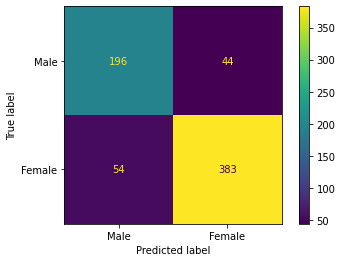

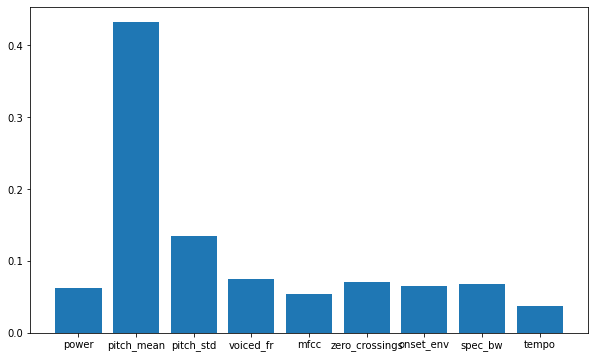

In [ ]:
import xgboost as xb
classifier=xb.XGBClassifier()
classifier.fit(X_train,y_train)

yt_p = classifier.predict(X_train)
yv_p = classifier.predict(X_val)

print('Training Accuracy', np.round(np.mean(yt_p==y_train),2))
print('Validation  Accuracy', np.round(np.mean(yv_p==y_val),2))
xgboost_val_accuracy=accuracy_score(y_val, yv_p)
cm = metrics.confusion_matrix(yv_p, (y_val))
print("\n")
#Confusion Matrix
cmd_obj=ConfusionMatrixDisplay(cm,display_labels=['Male','Female'])
cmd_obj.plot();
print("\n")
# classification report
print(classification_report(yv_p,y_val)) 
print("\n")
#plotting graph for contribution of features for this model
plt.figure (figsize=(10,6))
plt.bar(data.columns, classifier.feature_importances_)

**Inference:** *XG BOOST* model perfectly fits this application of identifying gender based on the extracted features from the audio.

This model has a training accuracy of 92% and testing accuracy of 86% which is slightly overfitting the model.

For the Male participitants this model has a precision, recall, fscore of 84%.

For the Female participitants this model has a precision, recall, fscore of 86%. It can be intrepretted that the model is slightly biased towards Female participants.

Pitch_mean has a higher feature importance score which represents that this feature has a higher impact while predicting the gender in this model.

**Furthur Analysis on XG boost model**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
parameters={
"eta"         :    [0.05,0.10,0.15,0.20,0.3,0.35],
"max_depth"             :    [3,4,5,7,10,12,15],
"min_child_weight"      :    [1,3,5,7],
"gamma"                 :    [1,2,3,4,5],
"colsample_bytree"      :    [0.4,0.5,0.7,1],
'n_estimators'          :     [150,200,250,300]
}

In [ ]:
cv=RandomizedSearchCV(classifier,param_distributions=parameters,cv=10,n_iter=10,scoring='roc_auc',n_jobs=-1,verbose=3,random_state=123)
cv.fit(X_train,y_train)
display(cv.best_estimator_)
yt_p = cv.predict(X_train)
yv_p = cv.predict(X_val)
print('Training Accuracy', np.round(np.mean(yt_p==y_train),2))
print('Validation  Accuracy', np.round(np.mean(yv_p==y_val),2))


Fitting 10 folds for each of 10 candidates, totalling 100 fits


XGBClassifier(colsample_bytree=0.7, eta=0.1, gamma=1, max_depth=15,
              min_child_weight=3, n_estimators=250)

Training Accuracy 1.0
Validation  Accuracy 0.86


**Inference**:Xg boost method using randomsearchcv is completly overfitting the training data which is not ideal for this problem statement.


**8.3 Model Traning and Evaluation using Random Forest Model**

Training Accuracy 0.9302473050095117
Validation  Accuracy 0.85
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       233
           1       0.91      0.87      0.89       444

    accuracy                           0.86       677
   macro avg       0.84      0.85      0.85       677
weighted avg       0.86      0.86      0.86       677



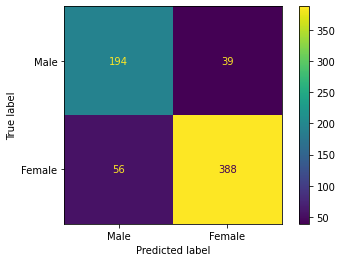

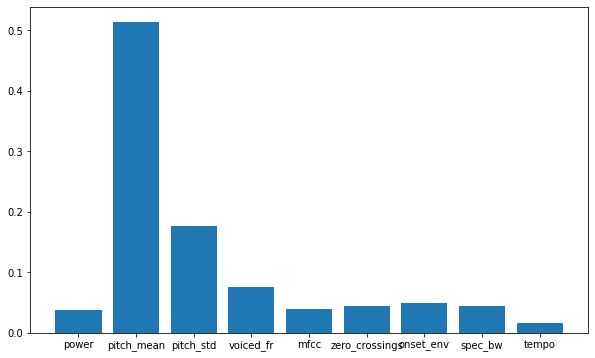

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_1=RandomForestClassifier(n_estimators=150,max_depth=7,max_features='sqrt',random_state=2)
rf_1.fit(X_train,y_train)
yt_p1 = rf_1.predict(X_train)
yv_p1 = rf_1.predict(X_val)

print('Training Accuracy', np.mean(yt_p1==y_train))
print('Validation  Accuracy',np.round(np.mean(yv_p1==y_val),2))
rf_val_accuracy=accuracy_score(y_val, yv_p1)

#Confusion Matrix
cm = metrics.confusion_matrix(yv_p, (y_val))
cmd_obj=ConfusionMatrixDisplay(cm,display_labels=['Male','Female'])
cmd_obj.plot()

# classification report
print(classification_report(yv_p,y_val)) 

#plotting graph for contribution of features for this model
plt.figure (figsize=(10,6))
plt.bar(data.columns, rf_1.feature_importances_)
plt.show()

**Inference:** RandomForest classifier has a training accuracy of 91% and a testing accuracy of 87%.

For the Male participitants it has a precision, recall, fscore of 84%.

For the Female participitants it has a precision, recall, fscore of 88%.

Pitch_mean has a huge impact while predicting the gender in this model. 

This model is slightly overfitting the training data. 


### **9.Conclusions:**



*   According to me, the XGboost model is the best model that fits 
this application and pitch_mean has a huge impact while predicting gender. All the inferences of each model are placed just below the model in this notebook.

*   Transforming and Scaling have made a huge difference while differentiating male and female participants.
*   Extracting various audio features is the most important part of this notebook. It made my application more convenient while data processing. Extracting more features also helped to distinguish gender-specific. 

